In [1]:
# import argparse
import datetime



In [2]:
env_id = 'BipedalWalker-v3'

agent_param_type = "vanilla"
agent_param_value = 0
agent_run_no = 0

gpu_id = 0
NUM_ENVS = 5 # The different number of processes that will be used
# TRAIN_STEPS = 1E6 # TRAIN_STEPS = 3E7 should result in 12E7 timesteps due to VecStack=4

In [3]:
import torch
torch.cuda.set_device(gpu_id)

In [4]:
import os
import sys
import git
import pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

print(f"Project Root Directory: {PROJ_ROOT}")

Project Root Directory: /repos/drl_csense


In [5]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from lib.folder_paths import get_exp_name_tag, deconstruct_exp_name, makeget_logging_dir
# from lib.env_utils import AtariWrapper_NoisyFrame, AtariWrapper_Compressed, make_atari_env_Custom_VecFrameStack, SaveBestModelCallback
from lib.env_utils import SaveBestModelCallback
from lib.vizresults import plot_single_run_rewards

In [6]:
from collections import deque
import scipy.fftpack as spfft
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')

In [7]:
# Get names and tags of experiment
exp_name, exp_metaname, exp_tag = get_exp_name_tag(env_id, agent_param_type, agent_param_value)

print(f"Agent: {exp_name}")
print(f"Using device: {torch.cuda.current_device()}")

# Get directories
models_dir, log_dir, gif_dir, image_dir = makeget_logging_dir(exp_name)

# ALgorithm to use
ALGO_TYPE = "SAC"
# ALGO_TYPE = "SAC"

ALGO_DICT = {"SAC": SAC, 
             "PPO": PPO}
ALGO = ALGO_DICT[ALGO_TYPE]

# Start Experiment
print("-------")
print(f"RUN: {agent_run_no}")

# Log directory for each run of the experiment
run_log_dir = f"{log_dir}/eval/run_{agent_run_no}"
eval_agent = ALGO.load(f"{models_dir}/{exp_name}-run_{agent_run_no}-{ALGO_TYPE}")

Agent: BipedalWalker-v3--vanilla_0
Using device: 0
-------
RUN: 0


In [8]:
f"{models_dir}/{exp_name}-run_{agent_run_no}-{ALGO_TYPE}"

'/repos/drl_csense/models/BipedalWalker-v3--vanilla/BipedalWalker-v3--vanilla_0/BipedalWalker-v3--vanilla_0-run_0-SAC'

In [9]:
MAX_ITER = int(1000)
alpha = 1e-3
num_stack = 25
A = spfft.idct(np.identity(num_stack), norm='ortho', axis=0)
lasso = Lasso(alpha=alpha, max_iter=MAX_ITER, warm_start=False, selection="random")

def reconstruct(lasso, A, noisy_signal):
    idx_nonzero = np.where(noisy_signal != 0)[0]
    Ac = A[idx_nonzero,:]
    b = noisy_signal[idx_nonzero]
    lasso.fit(Ac, b)
    Xat = np.array(lasso.coef_)
    Xa = spfft.idct(Xat,norm='ortho', axis=0 )
    return Xa

class RemoveAndRecover(gym.ObservationWrapper):
    def __init__(self, env: gym.Env, noise: float, num_stack: int, recover: bool):
        super().__init__(env)
        self.noise = noise
        self.num_stack = num_stack

        self.recover = recover
        self.raw_observation = None
        self.noisy_observation = None
        
        self.frames = deque(maxlen=self.num_stack)

        self.MAX_ITER = int(1000)
        self.alpha = 1e-5
        self.A = spfft.idct(np.identity(self.num_stack), 
                            norm='ortho', 
                            axis=0)
        self.lasso = Lasso(alpha=self.alpha, 
                           max_iter=self.MAX_ITER,
                           warm_start=False, 
                           selection="random")

    def observation(self, observation):
        # these dimensions are not compressible and so not corrupted by noise
        non_CS_dims = [1,4,5,6,7,8,10,11,12,13,23]
        # these dimensions are compressible and we shall corrupt them with noise
        CS_dims = [0,2,3,9,14,15,16,17,18,19,20,21,22]

        # add noise
        if self.noise == 0.0: # no noise added
            self.frames.append(observation)
            self.noisy_observation = observation
            return observation
        else:
            try:
                0.0 <= self.noise < 1.0
            except ValueError:
                print(f"Value of noise has to be in range [0,1). Got noise={noise}")
            noisemask = self.np_random.choice(a=[False, True], 
                                              size=observation.shape,
                                              p=[self.noise, 1.0-self.noise])
            dim_mask = np.zeros(shape=observation.shape)
            # these dimensions are not corrupted by noise
            dim_mask[non_CS_dims] = True
            noisemask = np.logical_or(noisemask, dim_mask)
            # print(noisemask)
            observation = noisemask * observation
            self.noisy_observation = observation.copy()

            if not self.recover:
                return observation
            else:
                # Do reconstruction
                # if none of the CS dims are zero, pass observation as it is
                CS_obs = observation[CS_dims]
                if np.all(CS_obs): # if none of the observation values is zero
                    # print("CS not active")
                    self.frames.append(observation)
                    return observation # pass observation as it is because CS is not required
                else: # otherwise
                    # print("CS active")
                    frame_array = np.array(self.frames).squeeze()
                    for dim in CS_dims: # for each dimension in observation
                        if observation[dim] == 0.0: # if the value of the dimension is zero (i.e., missing), use CS
                            noisy_signal = frame_array[:,dim]
                            reconstructed_signal = reconstruct(self.lasso, self.A, noisy_signal ) + np.mean(noisy_signal)
                            observation[dim] = reconstructed_signal[-1]
                    self.frames.append(observation)
                    return observation
                
    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        self.raw_observation = observation
        return self.observation(observation), reward, terminated, truncated, info
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        [self.frames.append(obs) for _ in range(self.num_stack)]
        return obs, info        

In [10]:
def eval_time_elapsed(single_eval_env, eval_agent, n_eval_episodes):
    timeperstep_rec = []
    for _ in range(n_eval_episodes):
        obs = single_eval_env.reset()
        timesteps = 0
        start = datetime.datetime.now()
        while True:
            timesteps += 1
            action, _ = eval_agent.predict(obs)
            obs, reward, done, _ = single_eval_env.step(action)
            if done:
                break
        elapsed = datetime.datetime.now() - start
        timeperstep = elapsed.total_seconds()/timesteps
        timeperstep_rec.append(timeperstep)
    return (np.array(timeperstep_rec).mean(), np.array(timeperstep_rec).std())

In [11]:
# Load and evaluate trained model
wrapper = RemoveAndRecover
noise_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
run_mother_seed = 20230930

non_CS_elapsed = []
CS_elapsed = []

In [12]:
for run in [0,1,3,4]:
    run_seed = run_mother_seed + run
    print(f"Run: {run}")
    for noise in noise_list:
        # Evaluation without CS recovery
        wrapper_kwargs = {"noise":noise,
                     "num_stack":num_stack,
                     "recover": False}
        single_eval_env = make_vec_env(env_id, 
                               n_envs=1,
                               monitor_dir=run_log_dir,
                               seed=run_seed,
                                wrapper_class=wrapper,
                                wrapper_kwargs = wrapper_kwargs,
                               vec_env_cls=DummyVecEnv)
        
        mean_timeperstep, std_timeperstep = eval_time_elapsed(single_eval_env, eval_agent, n_eval_episodes=5)
        non_CS_elapsed.append(mean_timeperstep)
        
        # Evaluation with CS recovery
        wrapper_kwargs = {"noise":noise,
                     "num_stack":num_stack,
                     "recover": True}
        
        eval_env = make_vec_env(env_id, 
                           n_envs=NUM_ENVS,
                           monitor_dir=run_log_dir,
                           seed=run_seed,
                            wrapper_class=wrapper,
                            wrapper_kwargs = wrapper_kwargs,
                           vec_env_cls=DummyVecEnv)
        
        mean_timeperstep, std_timeperstep = eval_time_elapsed(single_eval_env, eval_agent, n_eval_episodes=5)
        CS_elapsed.append(mean_timeperstep)

Run: 0
Run: 1
Run: 3
Run: 4


In [13]:
CS_elapsed_secs = np.array(CS_elapsed).reshape(-1,9)
non_CS_elapsed_secs = np.array(non_CS_elapsed).reshape(-1,9)

In [14]:
CS_elapsed_secs

array([[0.00064194, 0.00074517, 0.00075529, 0.00075458, 0.0007557 ,
        0.00076211, 0.00076831, 0.00077879, 0.00076741],
       [0.00064575, 0.00074307, 0.00075542, 0.000757  , 0.00076237,
        0.00075886, 0.00076631, 0.0007655 , 0.00076821],
       [0.0006458 , 0.00074462, 0.00074468, 0.00076089, 0.00076449,
        0.00076011, 0.00076239, 0.00076318, 0.00076695],
       [0.00064567, 0.00074243, 0.00074888, 0.00074892, 0.00075718,
        0.00076006, 0.00076038, 0.00076365, 0.00076181]])

In [15]:
CS_elapsed_secs_mean = np.mean(CS_elapsed_secs, axis=0)
CS_elapsed_secs_std = np.std(CS_elapsed_secs, axis=0)

non_CS_elapsed_secs_mean = np.mean(non_CS_elapsed_secs, axis=0)
non_CS_elapsed_secs_std = np.std(non_CS_elapsed_secs, axis=0)

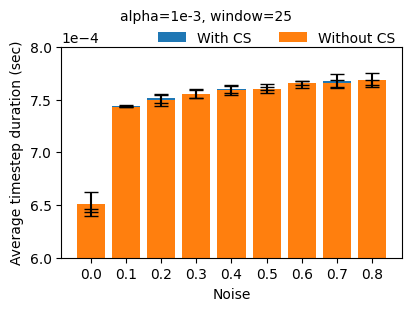

In [16]:
fig_width = 4
fig_height = 3
fig, axes = plt.subplots(nrows=1, 
                         ncols=1,
                         figsize=[fig_width,fig_height],
                         layout='constrained',
                         sharex=not True,
                         sharey=not True)

axes.bar(np.arange(len(CS_elapsed_secs_mean)), CS_elapsed_secs_mean, yerr=CS_elapsed_secs_std, align='center', ecolor='black', capsize=5, label="With CS")
axes.bar(np.arange(len(non_CS_elapsed_secs_mean)), non_CS_elapsed_secs_mean, yerr=non_CS_elapsed_secs_std, align='center', ecolor='black', capsize=5, label="Without CS")

axes.set(xlabel="Noise", ylabel="Average timestep duration (sec)")
axes.set_xticks(np.arange(len(noise_list)), noise_list)

axes.set_ylim([0.0006, 0.0008])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

fig.suptitle(f'alpha=1e-3, window=25', fontsize='medium');
fig.legend(ncols=2, bbox_to_anchor=(0.35, 0.825), loc='lower left', frameon=False);

In [17]:
fig.savefig("alpha3win25-timeelapsed.png")